# Brain tumor detection from MRI images
Group 9: Harshith Sheshan, Shiyao Wang, Albert Sankoh, Michael Hart

# Project Objectives:
Our primary research question is to train and tune a deep learning model that is able to predict whether a brain MRI image indicates that the patient has a tumor.</br>
We may also expand the use of our model to other datasets for validation, to make sure our model trained is sufficiently generalized.</br> 
If time permits, we would also like to explore if it is possible to further our prediction, that is, to localize the tumor by predicting which pixels on the image shall the tumor region cover.

# Dataset discription
Our primary dataset is the LGG Segmentation Dataset, which contains 3929 brain MRI images from 110 patients, together with manual FLAIR abnormality segmentation masks of each image.</br>
Images and masks are organized in 110 folders with naming convention of `TCGA_<institution-code>_<patient-id>_<slice-number>`</br>
All images are provided in `.tif` format with 3 channels per image. Masks are binary, 1-channel images, named the same with the corresponding image with a `_mask` suffix. </br>
There is also a lookup table `data_mask.csv` that stores the paths of each image and the mask corresponding to it.</br>

### Columns of the table include:
* patient_id: the id of the patients, will be dropped in preprocessing since our analysis regards each image as a datapoint
* image_path: the path to an image
* mask_path: the path of above image's mask
* mask: a binary variable
  * 1: if the mask has a light region, displaying a existing tumor
  * 0: if the mask is empty, saying no tumor seen on this MRI image

### Other datasets of brain scan images for tumor detection:
* https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
* https://figshare.com/articles/dataset/brain_tumor_dataset/1512427
* https://openfmri.org/dataset/ds000002/
* https://openneuro.org/datasets/ds002870/versions/1.0.1

Other datasets may not have the mask for each image, but as long as they provide a boolean tag saying tumor or non tumor status, they are good to use. </br>
In addition, given that the datasets don't have the image path lookup table, we can build or own and use the `tensorflow.keras_preprocessing.image.ImageDataGenerator` as well to preprocess them in a shape that can be directly fed to the model.


# Load the source data

In [ ]:
# Mount the folder path to the drive
from google.colab import drive
drive.mount('/content/drive')

# # Better unmount before remount, if we want it mounted to a different directory
# drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
# Come to the working folder including colab notebook and source data
%cd /content/drive/Shareddrives/6140Drive

/content/drive/Shareddrives/6140Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check structure of our shared drive
%ls 

'Colab Notebooks'/   trained_classifier-resnet-model.json
 report/             Trained_ResUNet_classifier.json
 source-data/


#### Check the data_mask.csv

In [ ]:
%cd /content/drive/Shareddrives/6140Drive/source-data/lgg-mri-segmentation

/content/drive/Shareddrives/6140Drive/source-data/lgg-mri-segmentation


In [ ]:
# # Upload data.csv and data_mask.csv to google drive while keeping the coma delimited format
# # This will prompt you to choose file to upload
# # (noticed that when a csv file was directly uploaded to google drive it lost the csv format)
# from google.colab import files
# uploaded = files.upload()

#Import all Libraries and our Dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

brain_df = pd.read_csv('data_mask.csv')

In [ ]:
brain_df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


#Let's do some data Visualizations


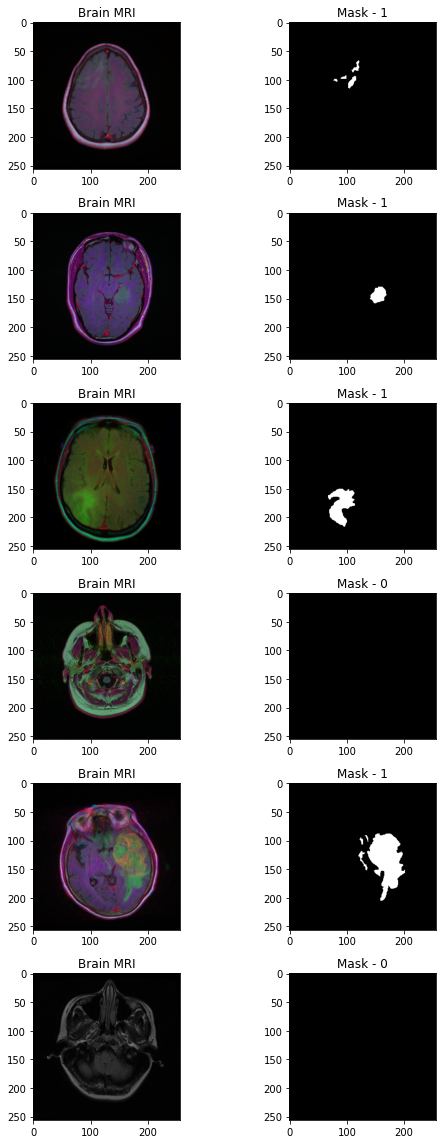

In [ ]:
# Visualizing the images (MRI and Mask) in the dataset to show Brain MRI and corresponding Mask 
import random
fig, axs = plt.subplots(6,2, figsize=(8,16))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # Display MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

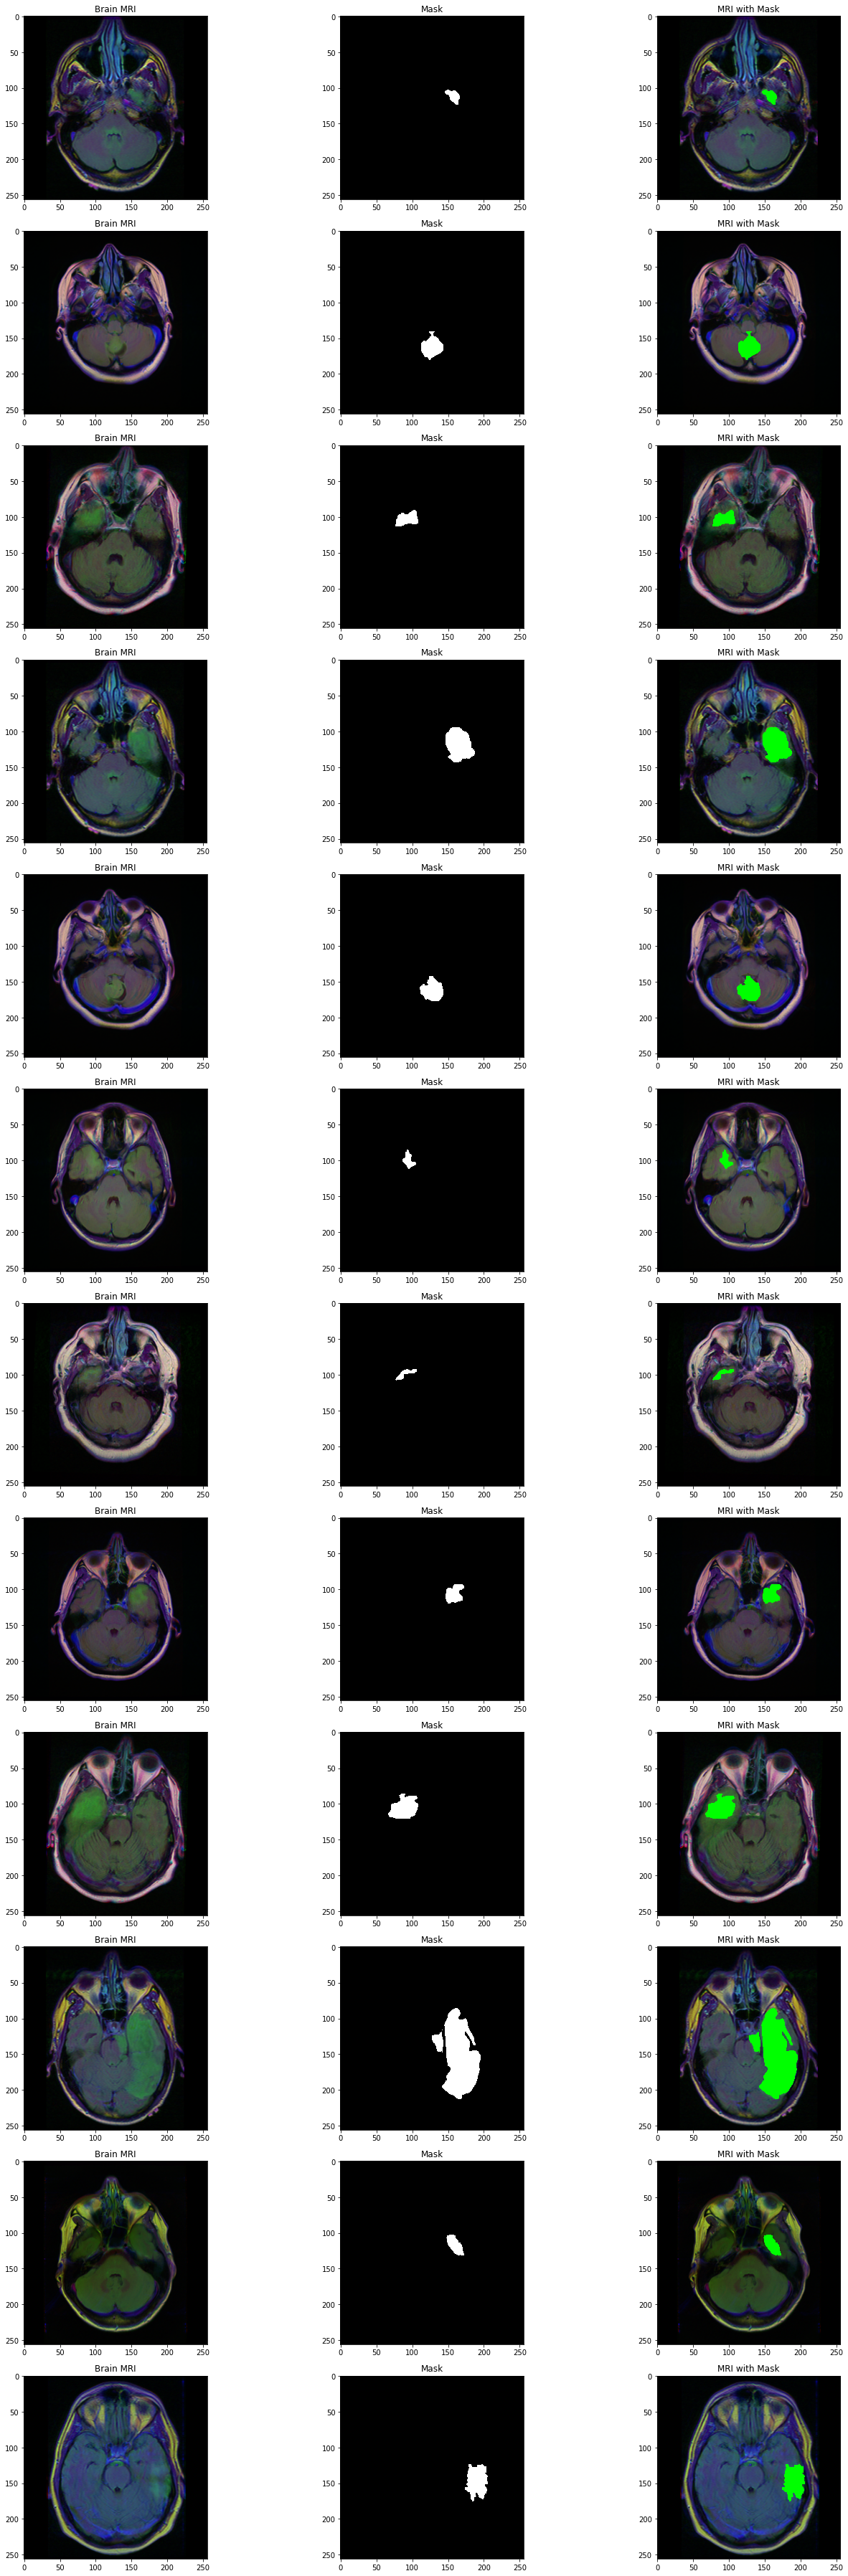

In [ ]:

# Visualizing the images (MRI, Mask and a combination of both) in the dataset to show Brain MRI, Mask and combination of both with Mask shown in green
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (0,255, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

# Preprocess the image data

In [ ]:
# Drop the patient_id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
# Split the data into train and test data
from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
# Create a data generator that scales the 0-255 pixel values to 0-1 range
# and makes the validation split of 0.15
from keras_preprocessing.image import ImageDataGenerator
# Create a data generator for training images
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)
# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

In [ ]:
# Stream the images by paths in the lookup table
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


# Train the model




In [ ]:
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize

basemodel = ResNet50(
    weights = 'imagenet', 
    include_top = False, 
    input_tensor = Input(shape=(256, 256, 3)))

basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# Freeze the model weights
for layer in basemodel.layers:
  layers.trainable = False


In [ ]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# Compile the model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer='adam', 
    metrics= ["accuracy", "AUC", "Recall", "Precision"])

In [ ]:
# Use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=10)

# Save the best model with least validation loss
checkpointer = ModelCheckpoint(
    filepath="classifier-resnet-weights.hdf5", 
    verbose=1, 
    save_best_only=True)

In [ ]:
history = model.fit(
    train_generator, 
    steps_per_epoch= train_generator.n // 16, 
    epochs = 5, 
    validation_data= valid_generator, 
    validation_steps= valid_generator.n // 16, 
    callbacks=[checkpointer, earlystopping])

Epoch 1/5
177/177 [==============================] - ETA: 0s - loss: 0.7435 - accuracy: 0.6776 - auc: 0.7429 - recall: 0.6776 - precision: 0.6776 
Epoch 1: val_loss improved from inf to 1.90890, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 2786s 16s/step - loss: 0.7435 - accuracy: 0.6776 - auc: 0.7429 - recall: 0.6776 - precision: 0.6776 - val_loss: 1.9089 - val_accuracy: 0.6815 - val_auc: 0.6815 - val_recall: 0.6815 - val_precision: 0.6815
Epoch 2/5
177/177 [==============================] - ETA: 0s - loss: 0.5149 - accuracy: 0.7435 - auc: 0.8346 - recall: 0.7435 - precision: 0.7435 
Epoch 2: val_loss improved from 1.90890 to 0.62868, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 2638s 15s/step - loss: 0.5149 - accuracy: 0.7435 - auc: 0.8346 - recall: 0.7435 - precision: 0.7435 - val_loss: 0.6287 - val_accuracy: 0.6815 - val_auc: 0.6958 - val_recall: 0.6815 - val_precision: 0.6815
Epoch 3/5
177/17

In [ ]:
# Show results of training model with 10 epochs
history_dict



{'loss': [0.762412428855896,
  0.46545255184173584,
  0.35115015506744385,
  0.32383453845977783,
  0.31216225028038025,
  0.2648840844631195,
  0.22284084558486938,
  0.2134944051504135,
  0.18349094688892365,
  0.19617107510566711],
 'accuracy': [0.6790648102760315,
  0.7966701984405518,
  0.8505136370658875,
  0.8714134097099304,
  0.8788523077964783,
  0.8877081274986267,
  0.9181721806526184,
  0.92206871509552,
  0.9344668984413147,
  0.9280906915664673],
 'auc': [0.732151448726654,
  0.8797751665115356,
  0.9277915358543396,
  0.9395571351051331,
  0.9447913765907288,
  0.95743328332901,
  0.9696259498596191,
  0.9721755385398865,
  0.979206919670105,
  0.9765116572380066],
 'recall': [0.6790648102760315,
  0.7966701984405518,
  0.8505136370658875,
  0.8714134097099304,
  0.8788523077964783,
  0.8877081274986267,
  0.9181721806526184,
  0.92206871509552,
  0.9344668984413147,
  0.9280906915664673],
 'precision': [0.6790648102760315,
  0.7966701984405518,
  0.8505136370658875,
  

Text(0.5, 1.0, 'Accuracy over training Epochs')

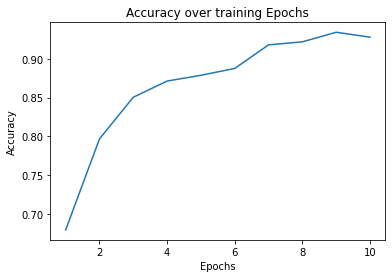

In [ ]:
# Show plot of how accuracy improves with epochs
import json
import matplotlib.pyplot as plt

# Load training history from drive - model was trained overnight with 10 epochs:
history_dict = json.load(open("history_10.json", 'r'))

epochs = range(1,11)
accuracy = history_dict['accuracy']
plt.plot(epochs, accuracy)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over training Epochs")

In [ ]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# Predict reuslts using test data
predictions = model.predict(test_generator, batch_size=128)
print("predictions shape:", predictions.shape)
labels = test.iloc[:-1]

37/37 [==============================] - 199s 5s/step
predictions shape: (590, 2)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Make class_predictions
class_predictions = []

for i in predictions:
  class_predictions.append(str(np.argmax(i)))

class_predictions = np.asarray(class_predictions)

# Make truth aray
truth = test['mask']

# Print Accuracy
accuracy = accuracy_score(truth, class_predictions)
print('Accuracy Score: ' + str(accuracy))

Accuracy Score: 0.9745762711864406


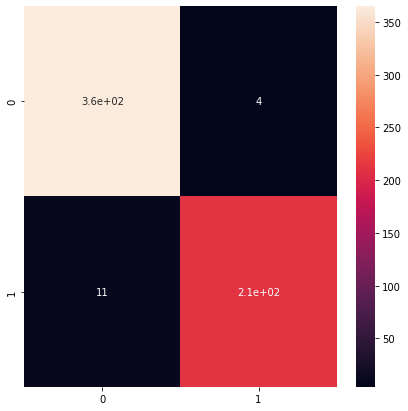

In [ ]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(truth, class_predictions)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
# Show the classification report by binary class
from sklearn.metrics import classification_report
print(classification_report(truth, class_predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       369
           1       0.98      0.95      0.97       221

    accuracy                           0.97       590
   macro avg       0.98      0.97      0.97       590
weighted avg       0.97      0.97      0.97       590



In [ ]:
# # Save the model architecture to json file for future use
model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

# Validate with another dataset
Source: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
This dataset contains 155 images with tumor and 98 without tumor. 

In [ ]:
%cd /content/drive/Shareddrives/6140Drive/source-data/dataset2

/content/drive/Shareddrives/6140Drive/source-data/dataset2


In [ ]:
import os 

df = pd.DataFrame(columns=['img_path', 'has_tumor'])
for filename in os.listdir("./yes"):
    filepath = "yes/" + filename
    df = df.append({'img_path':filepath, 'has_tumor':'1'}, ignore_index = True)

for filename in os.listdir("./no"):
    filepath = "no/" + filename
    df = df.append({'img_path':filepath, 'has_tumor':'0'}, ignore_index = True)

# df

In [ ]:
df.to_csv('dataset2_index.csv')

In [ ]:
import pandas as pd

df_valid2 = pd.read_csv('dataset2_index.csv')
df_valid2

,Unnamed: 0,img_path,has_tumor
0,0,yes/Y108.jpg,1
1,1,yes/Y154.jpg,1
2,2,yes/Y147.JPG,1
3,3,yes/Y148.JPG,1
4,4,yes/Y183.jpg,1
...,...,...,...
248,248,no/14_no.jpg,0
249,249,no/50_no.jpg,0
250,250,no/18_no.jpg,0
251,251,no/8_no.jpg,0


In [ ]:
from keras_preprocessing.image import ImageDataGenerator

# Prepare the lookup table for streaming the data files
df_valid2['has_tumor'] = df_valid2['has_tumor'].apply(lambda x: str(x))

valid2_datagen=ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=15,
                                   shear_range=0.1,
                                   zoom_range=0.5)

valid2_generator=valid2_datagen.flow_from_dataframe(
dataframe=df_valid2,
directory= './',
x_col='img_path',
y_col='has_tumor',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

Found 203 validated image filenames belonging to 2 classes.


In [ ]:
import tensorflow as tf

# Load pretrained model (instead of training the model for hours) 
with open('../lgg-mri-segmentation/resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

In [ ]:
# Recreate the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('../lgg-mri-segmentation/weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('../lgg-mri-segmentation/resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('../lgg-mri-segmentation/weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
valid2_predict = model.predict(valid2_generator, steps = valid2_generator.n // 16, verbose =1)

12/12 [==============================] - 41s 3s/step


In [ ]:
valid2_predict.shape

(192, 2)

In [ ]:
# Obtain the predicted class from the model prediction
import numpy as np

predict = []

for i in valid2_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)
predict

array(['1', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0',
       '1', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '1', '0',
       '1', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0',
       '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1',
       '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0',
       '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1',
       '0', '0', '1', '1', '0', '0', '0', '1', '1', '0', '1', '0', '0',
       '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '1',
       '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0',
       '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '1',
       '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0

In [ ]:
# Obtain the accuracy and confusion matrix of the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

truth = np.asarray(df_valid2['has_tumor'])[:len(predict)]
accuracy = accuracy_score(truth, predict)
print('Accuracy Score: ' + str(accuracy))

Accuracy Score: 0.3489583333333333


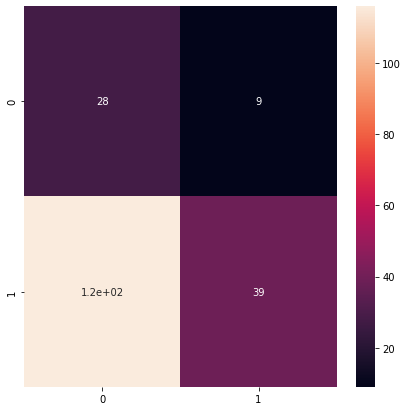

In [ ]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(truth, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
# Show the classification report by binary class
from sklearn.metrics import classification_report
print(classification_report(truth, predict))

              precision    recall  f1-score   support

           0       0.19      0.76      0.31        37
           1       0.81      0.25      0.38       155

    accuracy                           0.35       192
   macro avg       0.50      0.50      0.35       192
weighted avg       0.69      0.35      0.37       192



In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import cv2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Dropout
import tensorflow as tf
import splitfolders 
import pandas as pd
import glob
from sklearn.metrics import confusion_matrix
import itertools
#import plotly.graph_objects as go
#import plotly.express as px
#Suppressing Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
data_dir = "/content/drive/Shareddrives/6140Drive/source-data/dataset2"
data_dir =pathlib.Path(data_dir)

In [ ]:
Total_Images1 = glob.glob('/content/drive/Shareddrives/6140Drive/source-data/dataset2/*/*.jepg')
#print("Total number of images: ", len(Total_Images1))

Total_Images2 = glob.glob('/content/drive/Shareddrives/6140Drive/source-data/dataset2/*/*.jpg')

#print("Total number of images: ", len(Total_Images2))

Total_Images = Total_Images1 + Total_Images2
print("Total number of images: ", len(Total_Images))

Total_Images = pd.Series(Total_Images)

Total number of images:  171


In [ ]:
total_df = pd.DataFrame()

# generate Filename field
total_df['Filename'] = Total_Images.map( lambda img_name: img_name.split("/")[-1])


# generate ClassId field
total_df['ClassId'] = Total_Images.map(lambda img_name: img_name.split("/")[-2])

total_df.head()

,Filename,ClassId
0,N6.jpg,no
1,3_no.jpg,no
2,47_no.jpg,no
3,N15.jpg,no
4,15_no.jpg,no


In [ ]:
#Training Set contain 80% of data.

#Test Set contain 10% of data.

#Validation Set contain 10% of data

#create 3 different folders that contain each set with specific ratio (80-10-10)
splitfolders.ratio(data_dir, output="output", seed=101, ratio=(.8, .1, .1))

Copying files: 254 files [00:05, 46.42 files/s]


In [ ]:
#Create train/validation and test paths
train_path='./output/train/'
val_path='./output/val'
test_path='./output/test'
class_names=os.listdir(train_path)
class_names_val=os.listdir(val_path)
class_names_test=os.listdir(test_path)

In [ ]:
import glob
#Retrieve images with jpg and jpeg extension on the train set
train_image1 = glob.glob('./output/train/*/*.jpg')
train_image2 = glob.glob('./output/train/*/*.jpeg')
Total_TrainImages = train_image1 + train_image2
print("Total number of training images: ", len(Total_TrainImages))

#Retrieve images with jpg and jpeg extension on the test set
test_image1 = glob.glob('./output/test/*/*.jpg')
test_image2 = glob.glob('./output/test/*/*.jpeg')
Total_TestImages = test_image1 + test_image2
print("Total number of test images: ", len(Total_TestImages))


#Retrieve images with jpg and jpeg extension on the validation set
Val_image1 = glob.glob('./output/val/*/*.jpg')
Val_image2 = glob.glob('./output/val/*/*.jpeg')
Total_ValImages = Val_image1 + Val_image2
print("Total number of val images: ", len(Total_ValImages))

Total number of training images:  141
Total number of test images:  21
Total number of val images:  15


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
#Prepare the data generation and getting input images
#Using data augmentation on the train set
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
#prepare test set
test_datagen = ImageDataGenerator()
#prepare val set
val_datagen = ImageDataGenerator()
# read the images directly from the directory (each one its speciifc path)
#read train set
train_generator = train_datagen.flow_from_directory(train_path,target_size=(224, 224),batch_size=32,shuffle=True,class_mode='binary')
#read test set
test_generator = test_datagen.flow_from_directory(test_path,target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')
#read validation set
val_generator = val_datagen.flow_from_directory(val_path,target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')

Found 202 images belonging to 3 classes.
Found 27 images belonging to 3 classes.
Found 24 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
#load the  resnet50 model (transfer learning)
model = ResNet50(
      input_shape = (224,224,3),
      include_top = False,
      weights = 'imagenet'
    )

In [ ]:
#freeze model weights to not re-train on entire model for long time
for layers in model.layers:
    layers.trainable = False

In [ ]:
#adding some dense layers
from keras.layers import  Dropout
x = Flatten()(model.output)
x = Dropout(0.5)(x)
x = Dense(1, activation = "sigmoid")(x)

#recombine the models (resnet50 + dense layers)
model = keras.Model(model.input, x)
#compile
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = "accuracy")
#Get model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


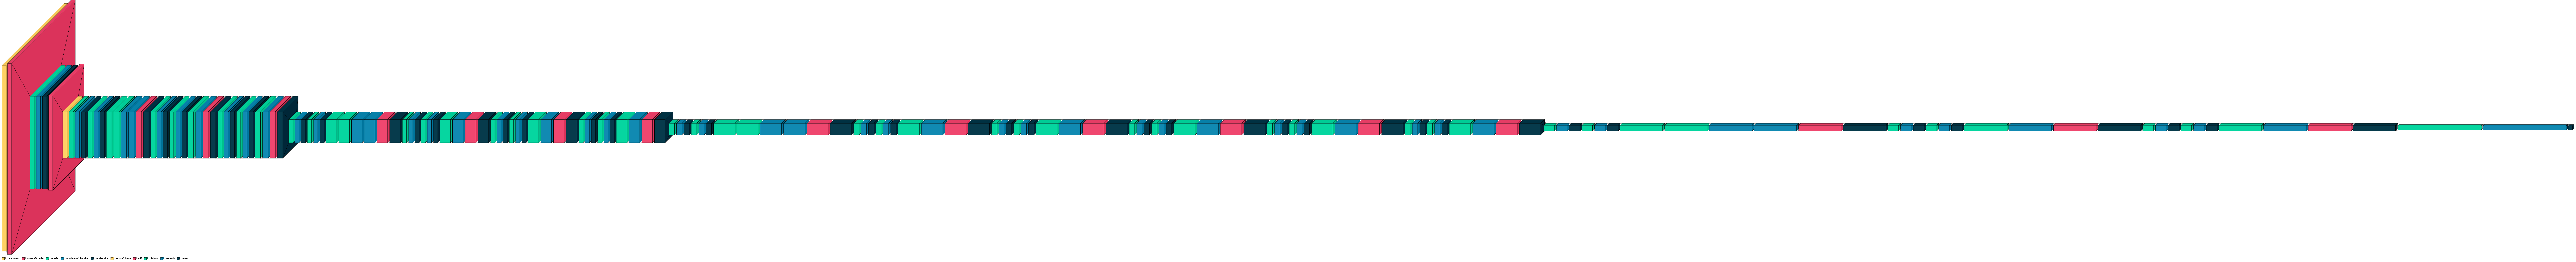

In [ ]:
#lets visualize our CNN model (in simple graphics)
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True) 

In [ ]:
#Set our ES
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [ ]:
#Set our MC
mc = ModelCheckpoint('./output/model.h5', monitor='val_accuracy', mode='max' )

In [ ]:
#Train the model
H = model.fit(train_generator,validation_data=val_generator,epochs=2,verbose=1, callbacks=[mc,es])

Epoch 1/2
7/7 [==============================] - 39s 5s/step - loss: -151.7370 - accuracy: 0.0000e+00 - val_loss: -177.4755 - val_accuracy: 0.0000e+00
Epoch 2/2
7/7 [==============================] - 39s 6s/step - loss: -191.3584 - accuracy: 0.0000e+00 - val_loss: -219.4189 - val_accuracy: 0.0000e+00


In [ ]:
#keep track on the history
hist = H.history
H.history

{'loss': [-21.83901023864746, -68.72322082519531],
 'accuracy': [0.05445544421672821, 0.0],
 'val_loss': [-49.33391189575195, -92.13407135009766],
 'val_accuracy': [0.0, 0.0]}

Text(0, 0.5, 'accuracy')

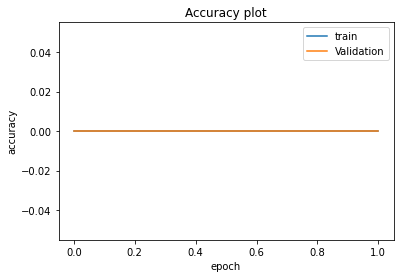

In [ ]:
#Plot a graph that shows the accuracy for both train and Validation
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","Validation"])
plt.xlabel("epoch")
plt.ylabel("accuracy")

Text(0, 0.5, 'loss')

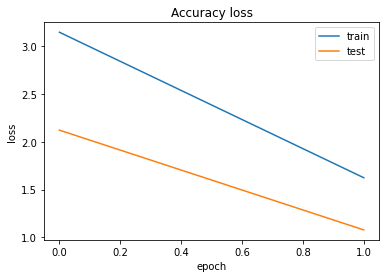

In [ ]:
#Figure that shows the loss for both train and val
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","Val"])
plt.xlabel("epoch")
plt.ylabel("loss")

In [ ]:
 #Check the Model performance on entire test set
 test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
 print('Loss: %.3f' % (test_loss * 100.0))
 print('Accuracy: %.3f' % (test_acc * 100.0)) 

1/1 [==============================] - 4s 4s/step - loss: 0.7204 - accuracy: 0.8148
Loss: 72.041
Accuracy: 81.481


# Conclusion
From above we can see that the model trained on the primary dataset has a sufficiently good performance on the itself.</br>
Yet when the model was transferably applied on another dataset, which generally has different image quality and coloring styles, the model lost much of the accuracy, in that it gave a lot of false negative, saying it was less able to recognize the tumor region. </br>
The model has better specificity though, compared to sensitivity, in that it did not really make a lot of false positive predictions.  </br>
With the naked eye observation, the external data images are more of a black-and-white coloring pattern with less contrast between tumor and non-tumor tissue, which is probably the reason why the model became less sensitive on the new dataset. </br>

# Future Scope
To make the model more generalizable regardless of image quality and coloring styles, we can first include multiple datasets in to our training.
In addition, we may want to incorporate some preprocessing on brightness and constrast to rule out their impact on predictions.